In [49]:
## Enviroment Setup
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # Set the visible CUDA, here we use the second GPU
WORKING_DIR = '/home/peizhi/Documents/gaussian-dejavu/'
os.chdir(WORKING_DIR) # change the working directory to the project's absolute path
print("Current Working Directory: ", os.getcwd())
sys.path.append(WORKING_DIR)
sys.path.append('./models')
sys.path.append('./networks')
sys.path.append('./utils')
sys.path.append('./utils/flame_lib/')
sys.path.append('./utils/diff-gaussian-rasterization')
sys.path.append('./utils/gaussian_renderer')
sys.path.append('./utils/scene')
sys.path.append('./utils/arguments')
sys.path.append('./utils/simple-knn')

import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm
import numpy as np
import cv2
import torch

from dejavu import GaussianDejavu
from utils.personal_video_utils import *

def min_max_normalize(image):
    norm_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    return norm_image

dejavu = GaussianDejavu(network_weights='./models/dejavu_network.pt', uv_map_size=320)
device = dejavu.device




Current Working Directory:  /home/peizhi/Documents/gaussian-dejavu
creating the FLAME Decoder
Framework v1.0 initialized.
Number of Gaussians:  74083
model loaded from:  ./models/dejavu_network.pt
Gaussian DejaVu Framework Created.


## Personal Data Loader

Number of frames: 3129.
img torch.Size([3, 512, 512, 3])
parsing (3, 512, 512)
vertices (3, 5023, 3)
blendshape_scores torch.Size([3, 52])
shape torch.Size([3, 100])
exp torch.Size([3, 50])
pose torch.Size([3, 6])
eye_pose torch.Size([3, 6])
tex torch.Size([3, 50])
light torch.Size([3, 9, 3])
cam torch.Size([3, 6])
img_masked torch.Size([3, 512, 512, 3])
masks torch.Size([3, 512, 512, 1])


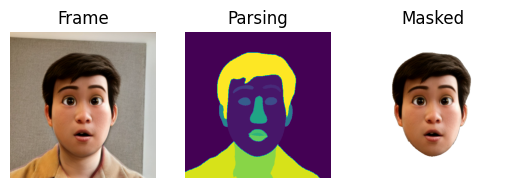

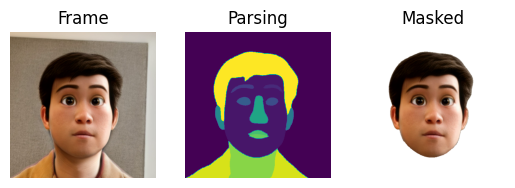

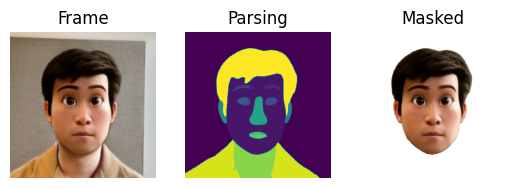

In [50]:
# First, follow the vToonify to stylize the video
# https://github.com/williamyang1991/VToonify

# Then, follow the flame-head-tracker to reconstruct the FLAME parameters  
# https://github.com/PeizhiYan/flame-head-tracker


dataset_path = '/mnt/data3_hdd/peizhi/Datasets/Personal_Videos_flame_new/peizhi-cartoon-3.2'
personal_dataloader = PersonalDataLoader(dataset_path=dataset_path, device=device, shuffle=True)

batch_data = personal_dataloader.next_random_batch(batch_size=3)

for key in batch_data:
    try:
        print(key, batch_data[key].shape)
    except:
        pass

for i in range(len(batch_data['fid'])):    
    plt.figure()
    plt.subplot(1,3,1)
    plt.imshow(batch_data['img'][i].detach().cpu()); plt.axis('off'); plt.title('Frame')
    plt.subplot(1,3,2)
    plt.imshow(batch_data['parsing'][i]); plt.axis('off'); plt.title('Parsing')
    plt.subplot(1,3,3)
    plt.imshow(batch_data['img_masked'][i].detach().cpu()); plt.axis('off'); plt.title('Masked')
    plt.show()



## Train

In [51]:
dejavu.personal_video_training(personal_dataloader, batch_size=16, steps_s1=150, steps_s2=300)


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/peizhi/miniconda3/envs/dejavu/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


Training Global...  Loss: 0.0081 LR: 0.0055: 100%|██████████| 150/150 [02:13<00:00,  1.12it/s]


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/peizhi/miniconda3/envs/dejavu/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


Training Blendmaps...  Loss: 0.0076 LR: 0.0068: 100%|██████████| 300/300 [05:05<00:00,  1.02s/it]


## Compare Results

In [52]:

with torch.no_grad():
    batch_data_test = personal_dataloader.next_random_batch(vid=None, batch_size=1)
    exp = batch_data_test['exp'][:,:50] # FLAME expression coefficients [N, n_expressions]
    pose = batch_data_test['pose'][:,3:] # FLAME jaw pose [N, 3]
    exp_pose = torch.cat([exp, pose], dim=1) # [N, n_expressions+3]
    logits = dejavu.mlp(exp_pose)
    blending_weights = torch.nn.functional.softmax(logits, dim=1)
    print(f'Blending Weights: ', blending_weights)


Blending Weights:  tensor([[0.1208, 0.0444, 0.0727, 0.1453, 0.1101, 0.1568, 0.0381, 0.0710, 0.0613,
         0.1794]], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

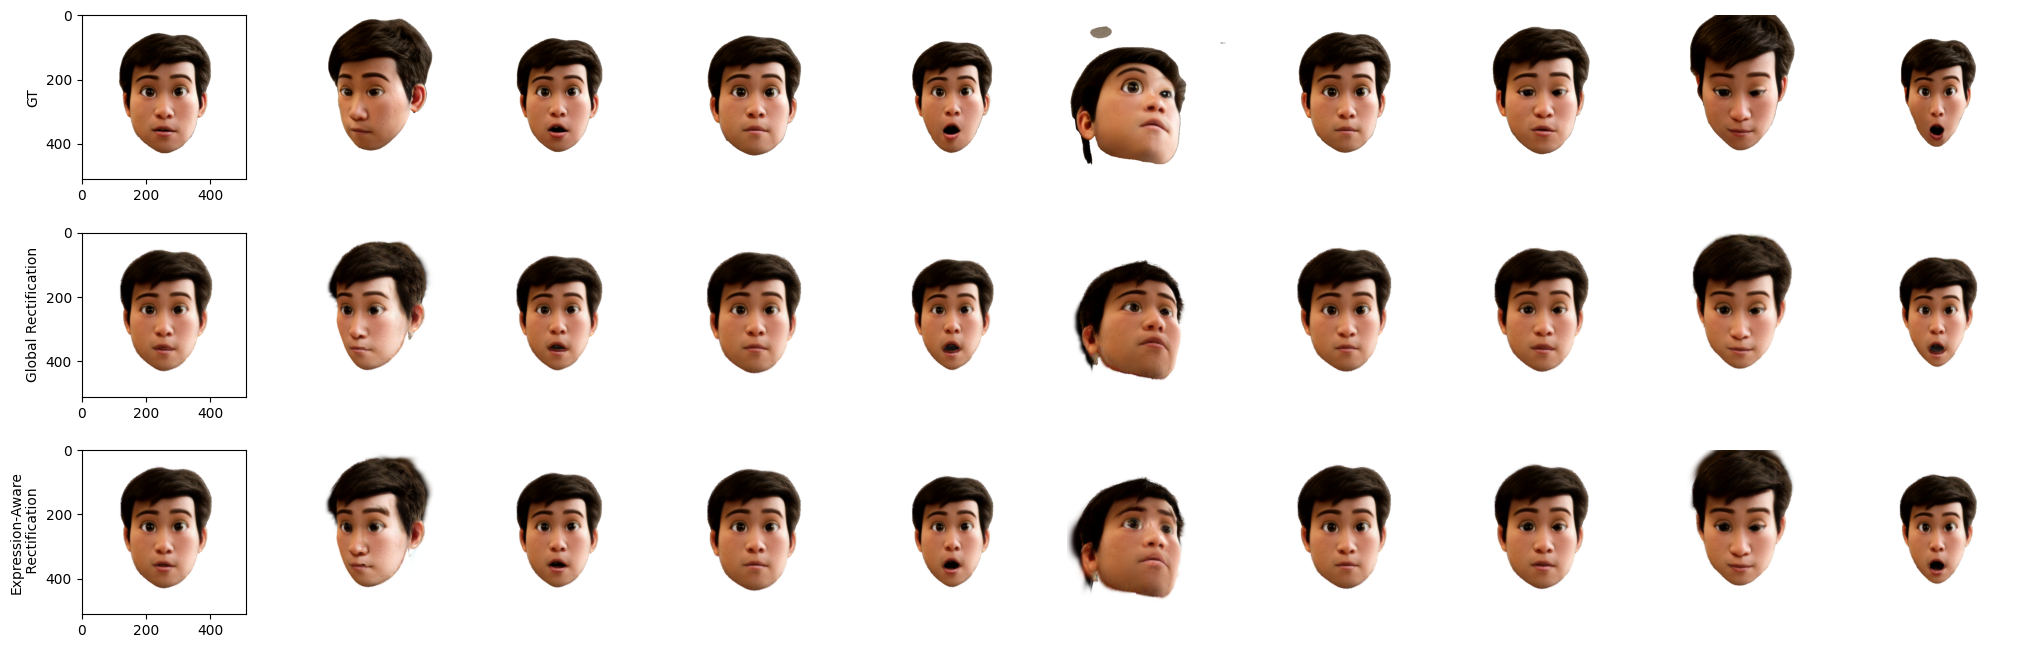

In [53]:

plt.figure(figsize=(25,8))

num_examples = 10
for i in range(num_examples):
    batch_data_test = personal_dataloader.next_random_batch(vid=None, batch_size=1)

    # Ground-Truth Frames (First Row)
    plt.subplot(3,num_examples,i+1)
    plt.imshow(batch_data_test['img_masked'][0].detach().cpu()); plt.axis('off')
    if i == 0: plt.axis('on'); plt.ylabel('GT')

    # Reconstructed, w/ Global Rectification (Second Row)
    plt.subplot(3,num_examples,num_examples+i+1)
    batch_rendered_global = dejavu._render_with_global_offsets_(batch_data_test, dejavu.global_uv_delta)
    plt.imshow(batch_rendered_global[0].detach().cpu().permute(1,2,0)); plt.axis('off')
    if i == 0: plt.axis('on'); plt.ylabel('Global Rectification')

    # Reconstructed, w/ Expression-Aware Rectification (Third Row)
    plt.subplot(3,num_examples,2*num_examples+i+1)
    batch_rendered_blend, _ = dejavu._render_with_blendmaps_(batch_data_test, dejavu.uv_delta_blendmaps)
    plt.imshow(batch_rendered_blend[0].detach().cpu().permute(1,2,0)); plt.axis('off')
    if i == 0: plt.axis('on'); plt.ylabel('Expression-Aware\n Rectification')

plt.show()



## Save Head Avatar

In [54]:
## save head avatar

dejavu.save_head_avatar(save_path='./saved_avatars', avatar_name='peizhi-cartoon-uv320-v1.1')



path exists, files will be overwrite
Head avatar parameters saved to ./saved_avatars/peizhi-cartoon-uv320-v1.1


## Load Head Avatar

In [55]:
## load head avatar

dejavu.load_head_avatar(save_path='./saved_avatars', avatar_name='peizhi-cartoon-uv320-v1.1')


Head avatar parameters loaded
